In [1]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import sys
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.
/home/andrea/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andrea/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andrea/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/andrea/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
print("Python version: ", sys.version)
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)

Python version:  3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
Keras version:  2.2.4
Tensorflow version:  1.14.0


In [3]:
seed = 1234
epoch = 40
batch_size = 50
folds = 10

In [4]:
# SET Hyper Parameters on a small dataset

In [5]:
#reproducibility
np.random.seed(seed)

#digits 1...9
D = 9

#percentage of whole data used as training
percent_train = 0.8

fname = "secretkeys_exe-b.csv"
dataset = np.loadtxt(fname, delimiter = ',', dtype = int)
N = len(dataset)

#now  we need to extract data and labels
s = dataset[:,0]     #string of first keys
y = dataset[:,-1]   #last column, 1 if key is present, 0 if not

#lenght of a string
L = len(str(s[0]))

#dimension of data sample
LD = L*D

#see how many samples we use for training
N_train = int(percent_train * N)

print(f'data: {N}')                         #must be 1000 as we generated it before
print(f'lenght of string: {L}')             #must be 6 because each keys is 6 digits long
print(f'dimension of my data sample: {LD}') #must be L*D = 6*9 = 54 
print(f'dimension of my training dataset: {N_train}') 
def expand(S):
    if(len(str(S))!=L):
        print('mismatch!')
        return[]
    
    x = [0] * LD
    p = 10**(L-1)
    j = 0
    while (j < L):
        q = int(S/p) #in this way we obtained the first digit
        
        # 1...9 ---> 0...8
        x[j*D + (q-1)] = 1
        j += 1
        S = S - q*p
        p = int(p/10)
    return x

#Split into training and test data

x_all = [None] * N

for i in range(N):
    x_all[i] = expand(s[i])

print(x_all[0]) #it must be the first one in the cell above

#split into train and test
x_train, y_train = x_all[0:N_train], y[0:N_train]
x_test , y_test  = x_all[N_train:] , y[N_train:]

print(len(x_train), '\t', len(x_test)) #should be 

#KERAS WANTS AS INPUT np.array()
x_train = np.array(x_train)                  # <--- we'd need to do this if the input data weren't of this kind
y_train = np.array(y_train)                  
x_test = np.array(x_test)                  
y_test = np.array(y_test)

print(x_train, np.shape(x_train))

def create_model(activations = 'relu',
                 drop_out = 0.2,
                 optimizer = 'adam',
                regularizer = 1.):
    np.random.seed(seed)
    model = Sequential()

    model.add(Dense(LD, input_shape = (LD,), activation = activations, activity_regularizer=l2(regularizer) )) #layer 0
    model.add(Dense(max(10, int(LD/2)), activation = activations, activity_regularizer=l2(regularizer))) #layer 1
    model.add(Dense(max(6, int(LD/4)), activation = activations, activity_regularizer=l2(regularizer))) #layer 2
 
    model.add(Dropout(drop_out))

    model.add(Dense((1), activation = 'sigmoid')) #final node
    model.compile(loss='binary_crossentropy', optimizer = str(optimizer), metrics=['accuracy'])
    
    return model

data: 3000
lenght of string: 7
dimension of my data sample: 63
dimension of my training dataset: 2400
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
2400 	 600
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]] (2400, 63)


# SMALL DATASET

BEST PARAMETERS SET FOUND IS:

In [6]:
best_activations = 'relu'
best_dropout = 0.25
best_optimizer = 'Adam'
best_regular = 0.01

In [7]:
best_model = create_model(activations = best_activations, 
                          drop_out = best_dropout, 
                          optimizer = best_optimizer,
                          regularizer = best_regular)

fit = best_model.fit(x_train, y_train, 
                     epochs = 40, 
                     batch_size = batch_size, 
                     validation_data = (x_test, y_test), shuffle = 1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2400 samples, validate on 600 samples
Epoch 1/40
2400/2400 [==============================] - 1s 256us/step - loss: 1.8685 - acc: 0.6450 - val_loss: 1.1247 - val_acc: 0.7383
Epoch 2/40
2400/2400 [==============================] - 0s 41us/step - loss: 0.9384 - acc: 0.7621 - val_loss: 0.8077 - val_acc: 0.7400
Epoch 3/40
2400/2400 [==============================] - 0s 46us/step - loss: 0.7507 - acc: 0.7633 - val_loss: 0.7135 - val_acc: 0.7400
Epoch 4/40
2400/2400 [==============================] - 0s 55us/step - loss: 0.6834 - acc: 0.7633 - val_loss: 0.6726 - val_acc: 0.7400
Epoch 5/40
2400/2400 [==============================] - 0s 42us/step - loss: 0.6516 - acc: 0.7633 - val_loss: 0.6500 - val_acc: 0.7400
Epoch 6/40
2400/2400 [==============================] - 0s 59u

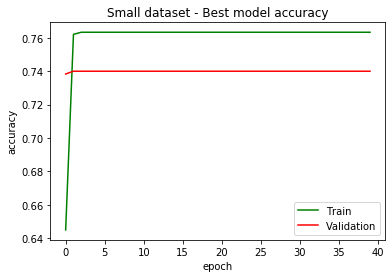

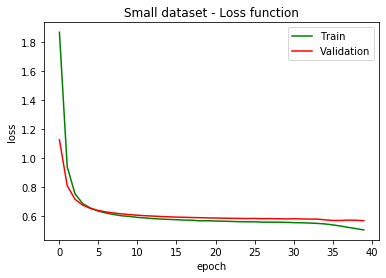

In [8]:
fit_accuracies = []
fit_losses = []

fit_accuracies.append(fit.history['acc'])
fit_accuracies.append(fit.history['val_acc'])


fit_losses.append(fit.history['loss'])
fit_losses.append(fit.history['val_loss'])

#plot accuracy both for training and validation  TENSORFLOW 1.14.0
plt.plot(fit.history['acc'], color = 'green')
plt.plot(fit.history['val_acc'], color = 'red')
plt.title('Small dataset - Best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

#plot loss function
plt.plot(fit.history['loss'], color = 'green')
plt.plot(fit.history['val_loss'], color = 'red')
plt.title('Small dataset - Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

# NOW WE RESHIFT

In [9]:
x_train_shift=(x_train-np.mean(x_train,axis=0))/np.std(x_train,axis=0) #rescaled data of the trainig set

x_test_shift=(x_test-np.mean(x_test,axis=0))/np.std(x_test,axis=0) #rescaled data of the validation set
print(len(x_train_shift))
print(np.shape(x_train_shift))
#Print(x_train)

2400
(2400, 63)


In [10]:
best_activations = 'relu'
best_dropout = 0.2
best_optimizer = 'Adam'
best_regular = 0.05

In [11]:
best_model = create_model(activations = best_activations, 
                          drop_out = best_dropout, 
                          optimizer = best_optimizer,
                          regularizer = best_regular)

fit = best_model.fit(x_train_shift, y_train, 
                     epochs = 40, 
                     batch_size = batch_size, 
                     validation_data = (x_test_shift, y_test), shuffle = 1)

Train on 2400 samples, validate on 600 samples
Epoch 1/40
2400/2400 [==============================] - 1s 259us/step - loss: 80.0067 - acc: 0.5063 - val_loss: 53.1534 - val_acc: 0.6217
Epoch 2/40
2400/2400 [==============================] - 0s 48us/step - loss: 40.8610 - acc: 0.6821 - val_loss: 30.9041 - val_acc: 0.7117
Epoch 3/40
2400/2400 [==============================] - 0s 44us/step - loss: 23.4400 - acc: 0.7512 - val_loss: 17.7440 - val_acc: 0.7383
Epoch 4/40
2400/2400 [==============================] - 0s 55us/step - loss: 13.0968 - acc: 0.7625 - val_loss: 9.9130 - val_acc: 0.7400
Epoch 5/40
2400/2400 [==============================] - 0s 49us/step - loss: 7.1851 - acc: 0.7629 - val_loss: 5.5248 - val_acc: 0.7400
Epoch 6/40
2400/2400 [==============================] - 0s 51us/step - loss: 3.9743 - acc: 0.7633 - val_loss: 3.1822 - val_acc: 0.7400
Epoch 7/40
2400/2400 [==============================] - 0s 51us/step - loss: 2.3137 - acc: 0.7633 - val_loss: 1.9609 - val_acc: 0.7400


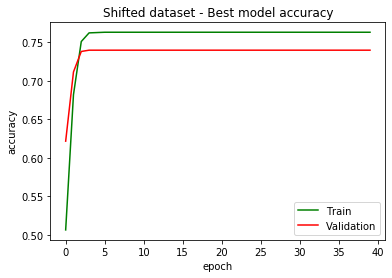

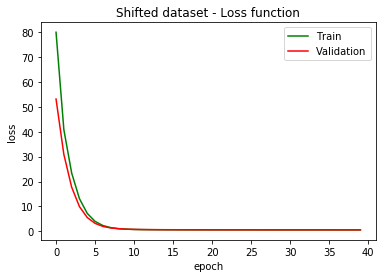

In [12]:
fit_accuracies.append(fit.history['acc'])
fit_accuracies.append(fit.history['val_acc'])

fit_losses.append(fit.history['loss'])
fit_losses.append(fit.history['val_loss'])

#plot accuracy both for training and validation  TENSORFLOW 1.14.0
plt.plot(fit.history['acc'], color = 'green')
plt.plot(fit.history['val_acc'], color = 'red')
plt.title('Shifted dataset - Best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

#plot loss function
plt.plot(fit.history['loss'], color = 'green')
plt.plot(fit.history['val_loss'], color = 'red')
plt.title('Shifted dataset - Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

# AUGMENTING DATA

In [13]:
def expand_augment(data, label, shift_augment = False):
    S = data 
    if(len(str(S))!=L):
        print('mismatch!')
        return[]
    
    x_temp = [0] * LD
    y_temp = label
    
    p = 10**(L-1)
    j = 0
    
    while (j < L):
        q = int(S/p) #in this way we obtained the first digit (MSD)
        
        # 1...9 ---> 0...8
        x_temp[j*D + (q-1)] = 1
        j += 1
        S = S - q*p
        p = int(p/10)
    
    if (shift_augment):
        x_aug  = [0] * LD * L
        x_aug  = np.reshape(x_aug, (L, LD))
        y_aug  = np.array([0]*L)
    
        for combination in range(L): #for each combination possible by shifting
            for index in range(LD):
                x_aug[combination][(index + combination*D)%LD] = x_temp[index]
            y_aug[combination] = label 
            
        return x_aug, y_aug
    
    else: return x_temp, y_temp

#print(dataset[1][0],   '---->', expand_augment(dataset[1][0], dataset[1][1], True))

data_augmented = [None]*N*L*2
data_augmented = np.reshape(data_augmented, (L*N,2))

for i in range(N):
    x_aug_temp, y_aug_temp = expand_augment(dataset[i][0], dataset[i][1], True)
    
    for j in range(len(x_aug_temp)):
        data_augmented[j + i*L][0] = x_aug_temp[j]
        data_augmented[j + i*L][1] = y_aug_temp[j]

#New N from data augmentation
N_new = len(data_augmented)
        
#see how many samples we use for training and then RESHUFFLE
N_train = int(percent_train * N_new)
np.random.shuffle(data_augmented)

print(np.shape(data_augmented[0:N_train,0]))

print(f'data: {N_new}')                         
print(f'lenght of string: {L}')             
print(f'dimension of my new data sample: {LD}') 
print(f'dimension of my new training dataset: {N_train}') 

#split into train and test

x_train = [[i for i in j] for j in data_augmented[0:N_train,0]]
x_test  = [[i for i in j] for j in data_augmented[N_train:,0]]
y_train = data_augmented[0:N_train,1]
y_test  = data_augmented[N_train:,1]

#print(len(x_train), '\t', len(x_test)) #should be 

#KERAS WANTS AS INPUT np.array()
x_train = np.array(x_train)                  # <--- we'd need to do this if the input data weren't of this kind
y_train = np.array(y_train)                 # <--- THIS IS OK
x_test = np.array(x_test)                  
y_test = np.array(y_test)

(16800,)
data: 21000
lenght of string: 7
dimension of my new data sample: 63
dimension of my new training dataset: 16800


In [14]:
best_activations = 'sigmoid'
best_dropout = 0.15
best_optimizer = 'Nadam'
best_regular = 0.05

In [15]:
best_model = create_model(activations = best_activations, 
                          drop_out = best_dropout, 
                          optimizer = best_optimizer,
                          regularizer = best_regular)

fit = best_model.fit(x_train, y_train, 
                     epochs = 40, 
                     batch_size = batch_size, 
                     validation_data = (x_test, y_test), shuffle = 1)

Train on 16800 samples, validate on 4200 samples
Epoch 1/40
16800/16800 [==============================] - 1s 82us/step - loss: 17.0666 - acc: 0.7568 - val_loss: 6.0275 - val_acc: 0.7598
Epoch 2/40
16800/16800 [==============================] - 1s 37us/step - loss: 4.4736 - acc: 0.7584 - val_loss: 3.4416 - val_acc: 0.7598
Epoch 3/40
16800/16800 [==============================] - 1s 35us/step - loss: 2.9010 - acc: 0.7584 - val_loss: 2.4681 - val_acc: 0.7598
Epoch 4/40
16800/16800 [==============================] - 1s 37us/step - loss: 2.1842 - acc: 0.7584 - val_loss: 1.9383 - val_acc: 0.7598
Epoch 5/40
16800/16800 [==============================] - 1s 42us/step - loss: 1.7611 - acc: 0.7584 - val_loss: 1.6011 - val_acc: 0.7598
Epoch 6/40
16800/16800 [==============================] - 1s 39us/step - loss: 1.4794 - acc: 0.7584 - val_loss: 1.3669 - val_acc: 0.7598
Epoch 7/40
16800/16800 [==============================] - 1s 37us/step - loss: 1.2789 - acc: 0.7584 - val_loss: 1.1951 - val_acc

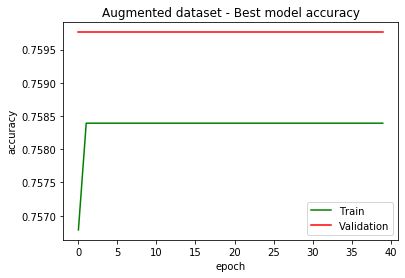

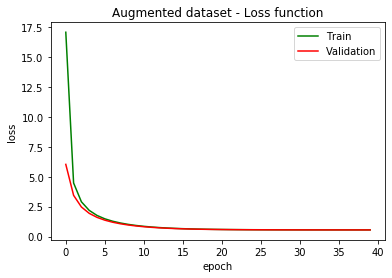

In [16]:
fit_accuracies.append(fit.history['acc'])
fit_accuracies.append(fit.history['val_acc'])

fit_losses.append(fit.history['loss'])
fit_losses.append(fit.history['val_loss'])

#plot accuracy both for training and validation  TENSORFLOW 1.14.0
plt.plot(fit.history['acc'], color = 'green')
plt.plot(fit.history['val_acc'], color = 'red')
plt.title('Augmented dataset - Best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

#plot loss function
plt.plot(fit.history['loss'], color = 'green')
plt.plot(fit.history['val_loss'], color = 'red')
plt.title('Augmented dataset - Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

# SHIFTED + AUGMENTED

In [17]:
x_train_shift=(x_train-np.mean(x_train,axis=0))/np.std(x_train,axis=0) #rescaled data of the trainig set

x_test_shift=(x_test-np.mean(x_test,axis=0))/np.std(x_test,axis=0) #rescaled data of the validation set
print(len(x_train_shift))
print(np.shape(x_train_shift))
#rint(x_train)

16800
(16800, 63)


In [18]:
best_activations = 'sigmoid'
best_dropout = 0.15
best_optimizer = 'Nadam'
best_regular = 0.1

In [19]:
best_model = create_model(activations = best_activations, 
                          drop_out = best_dropout, 
                          optimizer = best_optimizer,
                          regularizer = best_regular)

fit = best_model.fit(x_train_shift, y_train, 
                     epochs = 40, 
                     batch_size = batch_size, 
                     validation_data = (x_test_shift, y_test), shuffle = 1)

Train on 16800 samples, validate on 4200 samples
Epoch 1/40
16800/16800 [==============================] - 1s 80us/step - loss: 73.5952 - acc: 0.7567 - val_loss: 43.5478 - val_acc: 0.7598
Epoch 2/40
16800/16800 [==============================] - 1s 40us/step - loss: 31.8319 - acc: 0.7584 - val_loss: 22.9225 - val_acc: 0.7598
Epoch 3/40
16800/16800 [==============================] - 1s 37us/step - loss: 17.8821 - acc: 0.7584 - val_loss: 13.8428 - val_acc: 0.7598
Epoch 4/40
16800/16800 [==============================] - 1s 39us/step - loss: 11.3526 - acc: 0.7584 - val_loss: 9.2712 - val_acc: 0.7598
Epoch 5/40
16800/16800 [==============================] - 1s 37us/step - loss: 7.8778 - acc: 0.7584 - val_loss: 6.6792 - val_acc: 0.7598
Epoch 6/40
16800/16800 [==============================] - 1s 36us/step - loss: 5.8237 - acc: 0.7584 - val_loss: 5.0638 - val_acc: 0.7598
Epoch 7/40
16800/16800 [==============================] - 1s 38us/step - loss: 4.5012 - acc: 0.7584 - val_loss: 3.9899 - v

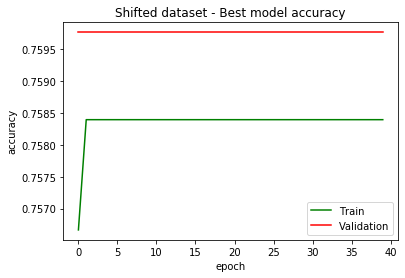

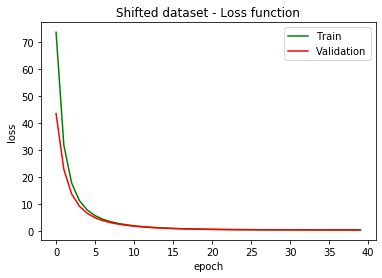

In [20]:
fit_accuracies.append(fit.history['acc'])
fit_accuracies.append(fit.history['val_acc'])

fit_losses.append(fit.history['loss'])
fit_losses.append(fit.history['val_loss'])

#plot accuracy both for training and validation
plt.plot(fit.history['acc'],color = 'green')
plt.plot(fit.history['val_acc'], color = 'red')
plt.title('Shifted dataset - Best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

#plot loss function
plt.plot(fit.history['loss'], color = 'green')
plt.plot(fit.history['val_loss'], color = 'red')
plt.title('Shifted dataset - Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'])
plt.show()

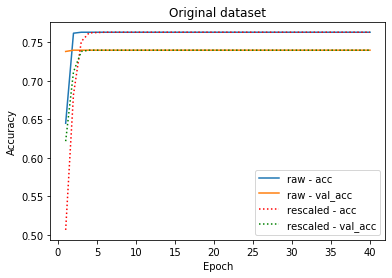

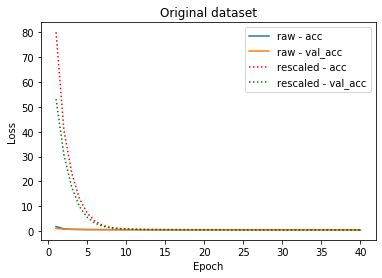

In [21]:
plt.plot(np.arange(1,41), fit_accuracies[0], label = "raw - acc")
plt.plot(np.arange(1,41), fit_accuracies[1], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_accuracies[2], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_accuracies[3], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Original dataset")
plt.legend()
plt.show()


plt.plot(np.arange(1,41), fit_losses[0], label = "raw - acc")
plt.plot(np.arange(1,41), fit_losses[1], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_losses[2], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_losses[3], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Original dataset")
plt.legend()
plt.show()

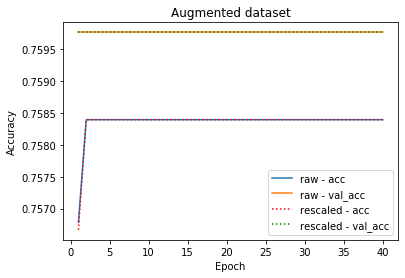

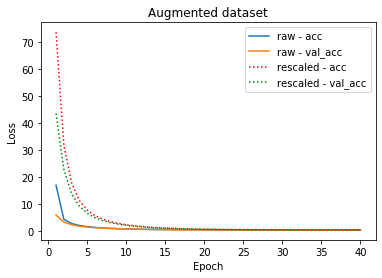

In [22]:
plt.plot(np.arange(1,41), fit_accuracies[4], label = "raw - acc")
plt.plot(np.arange(1,41), fit_accuracies[5], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_accuracies[6], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_accuracies[7], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Augmented dataset")
plt.legend()
plt.show()


plt.plot(np.arange(1,41), fit_losses[4], label = "raw - acc")
plt.plot(np.arange(1,41), fit_losses[5], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_losses[6], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_losses[7], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Augmented dataset")
plt.legend()
plt.show()

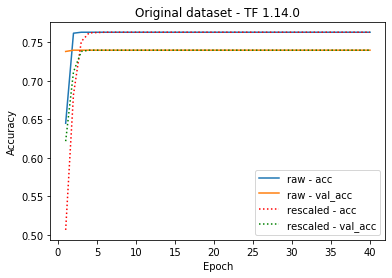

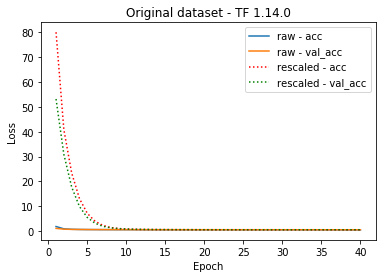

In [23]:
plt.plot(np.arange(1,41), fit_accuracies[0], label = "raw - acc")
plt.plot(np.arange(1,41), fit_accuracies[1], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_accuracies[2], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_accuracies[3], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Original dataset - TF 1.14.0")
plt.legend()
plt.show()


plt.plot(np.arange(1,41), fit_losses[0], label = "raw - acc")
plt.plot(np.arange(1,41), fit_losses[1], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_losses[2], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_losses[3], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Original dataset - TF 1.14.0")
plt.legend()
plt.show()

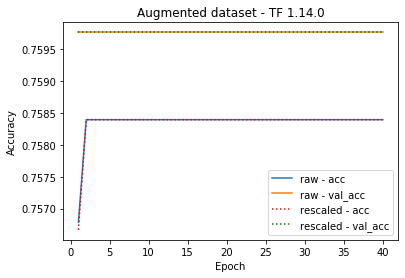

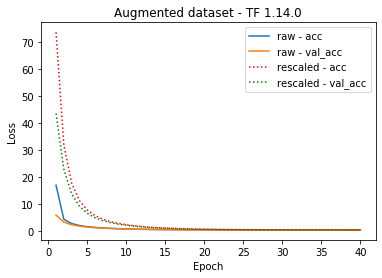

In [24]:
plt.plot(np.arange(1,41), fit_accuracies[4], label = "raw - acc")
plt.plot(np.arange(1,41), fit_accuracies[5], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_accuracies[6], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_accuracies[7], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Augmented dataset - TF 1.14.0")
plt.legend()
plt.show()


plt.plot(np.arange(1,41), fit_losses[4], label = "raw - acc")
plt.plot(np.arange(1,41), fit_losses[5], label = "raw - val_acc")
plt.plot(np.arange(1,41), fit_losses[6], color = 'red', linestyle = 'dotted', label = "rescaled - acc")
plt.plot(np.arange(1,41), fit_losses[7], color = 'green', linestyle = 'dotted', label = "rescaled - val_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Augmented dataset - TF 1.14.0")
plt.legend()
plt.show()